# Train on raw dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms, datasets, models
import transformers
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer
from accelerate import Accelerator
import matplotlib.pyplot as plt
import os
import sklearn.preprocessing
import numpy as np
from tqdm import tqdm
# import timm

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cpu


In [ ]:
def func_transform():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform

transformed = func_transform()

def loadDataset(transform_params):
    full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/demo_datasets_week8_H', transform= transform_params)



In [ ]:
full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/demo_datasets_week8_H', transform= transformed)

In [ ]:
total_size = len(full_dataset)
print(total_size)

6000


In [ ]:
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, )

In [ ]:
print(f"Number of total samples: {total_size}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Class names: {full_dataset.classes}")

Number of total samples: 6000
Number of training samples: 4800
Number of test samples: 1200
Number of classes: 6
Class names: ['ADI', 'DEBRIS_MUCUS', 'LYM', 'MUSC_STROMA', 'NORM', 'TUM']


In [ ]:
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


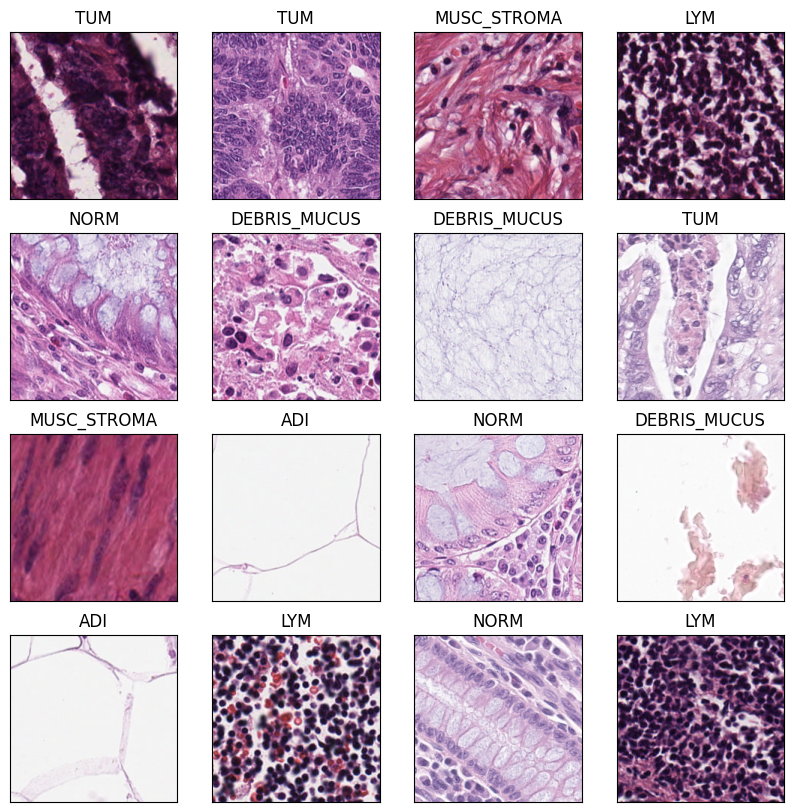

In [ ]:
plot_loader_ = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Visualise some examples
plt.figure(figsize=(10,10))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(plot_loader_))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))
    #image = image * std +mean
    plt.imshow(image)
    plt.title(full_dataset.classes[label])
plt.show()

In [ ]:
batch[1].numpy()[0]

2

In [ ]:
model1 = models.resnet50(pretrained=True).to(device)

for param in model1.parameters():
    param.requires_grad = False

model1.fc = nn.Sequential(
    nn.Linear(512, len(full_dataset.classes), bias=True)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


In [ ]:
model2 = models.vgg16(pretrained=True).to(device)

for param in model1.parameters():
    param.requires_grad = False

model2.classifier[-1] = nn.Linear(4096, len(full_dataset.classes), bias=True)
model2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model = model2
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Loop over minibatches
    for inputs, labels in train_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    # Update learning rate
    scheduler.step()

    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)

In [ ]:
def evaluate_one_epoch(test_loader, model, criterion):
    # Eval mode
    model.eval()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in test_loader:
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss
            loss_epoch += loss.detach().item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    return loss_epoch/len(test_loader), accuracy_epoch.item()/len(test_loader)

In [ ]:
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, save_name):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.savefig(save_name)
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True):
    # Initialise outputs
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    # Loop over epochs
    for epoch in range(10):
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)

        # Evaluate
        test_loss, test_accuracy = evaluate_one_epoch(test_loader, model, criterion)

        # Track metrics
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)

        # Print loss
        if verbose:
            if (epoch+1)%1==0:
                print(f'Epoch {epoch+1}/{10}, loss {train_loss:.5f}, test_loss {test_loss:.5f}, accuracy {train_accuracy:.5f}, test_accuracy {test_accuracy:.5f}')

    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [ ]:
train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True)

Epoch 1/10, loss 1.35089, test_loss 1.30073, accuracy 0.42312, test_accuracy 0.43832
Epoch 2/10, loss 1.04507, test_loss 0.88942, accuracy 0.55729, test_accuracy 0.61102
Epoch 3/10, loss 0.91354, test_loss 1.04623, accuracy 0.62687, test_accuracy 0.55510
Epoch 4/10, loss 0.86605, test_loss 0.84590, accuracy 0.65708, test_accuracy 0.66118
Epoch 5/10, loss 0.76672, test_loss 0.74226, accuracy 0.68625, test_accuracy 0.69079
Epoch 6/10, loss 0.64606, test_loss 0.67298, accuracy 0.73354, test_accuracy 0.72368
Epoch 7/10, loss 0.55898, test_loss 0.55894, accuracy 0.77208, test_accuracy 0.78454
Epoch 8/10, loss 0.47541, test_loss 0.56624, accuracy 0.80646, test_accuracy 0.78289
Epoch 9/10, loss 0.40513, test_loss 0.56495, accuracy 0.83562, test_accuracy 0.78454
Epoch 10/10, loss 0.36195, test_loss 0.55117, accuracy 0.85896, test_accuracy 0.79030


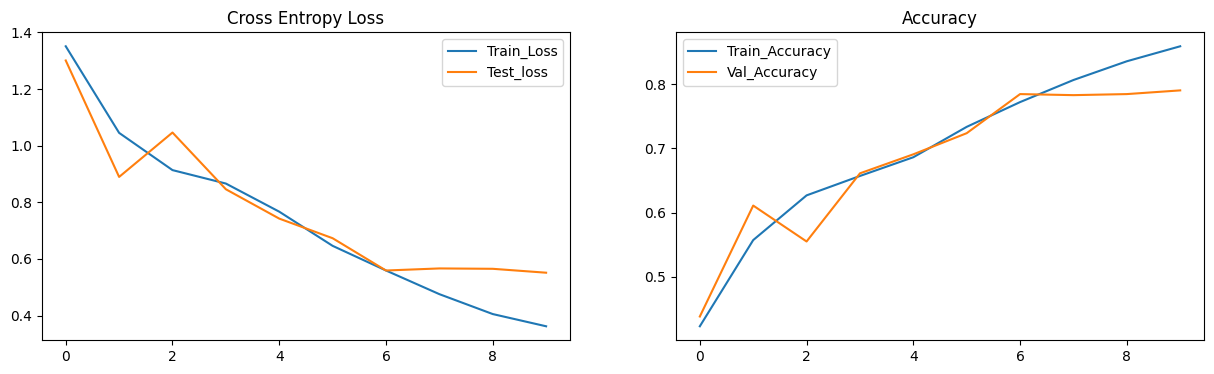

In [ ]:
plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, '/content/drive/MyDrive/vgg.png')

In [ ]:
model.eval()

with torch.no_grad():
    n_correct=0
    n_samples=0

    n_class_correct = [0 for i in range(len(full_dataset.classes))]
    n_class_sample = [0 for i in range(len(full_dataset.classes))]

    for inputs, labels in test_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predictions
        _, preds = torch.max(outputs, 1)

        n_samples += labels.shape[0]
        n_correct += (preds == labels.data).sum().item()

        for i in range(32):
            try:
                label = labels[i].item()
                pred = preds[i].item()
            except:
                break

            if (label==pred):
                n_class_correct[label]+=1
            n_class_sample[label]+=1

    acc = 100 * n_correct/n_samples
    print(f'Overall accuracy on test set: {acc:.1f} %')

    for i in range(len(full_dataset.classes)):
        print(f'Accuracy of {full_dataset.classes[i]}: {100* n_class_correct[i]/n_class_sample[i]:.1f} %')

Overall accuracy on test set: 78.8 %
Accuracy of ADI: 97.4 %
Accuracy of DEBRIS_MUCUS: 35.2 %
Accuracy of LYM: 89.3 %
Accuracy of MUSC_STROMA: 81.0 %
Accuracy of NORM: 83.7 %
Accuracy of TUM: 89.9 %


In [ ]:
from sklearn.metrics import classification_report
all_predictions, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=['ADI', 'DEB', 'LYM', 'MUS', 'NORM', 'TUM'], digits=4)

print(report)

              precision    recall  f1-score   support

         ADI     0.9592    0.9741    0.9666       193
         DEB     0.6250    0.3521    0.4505       213
         LYM     0.9511    0.8929    0.9211       196
         MUS     0.5686    0.8101    0.6682       179
        NORM     0.8114    0.8371    0.8241       221
         TUM     0.8203    0.8990    0.8578       198

    accuracy                         0.7883      1200
   macro avg     0.7893    0.7942    0.7814      1200
weighted avg     0.7901    0.7883    0.7788      1200



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Define the target class index for "TUM"
tum_class_idx = full_dataset.class_to_idx['TUM']

# Initialize lists to store all predictions and labels
all_preds = []
all_labels = []

# Collect predictions and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate micro-average precision, recall, f1-score for "TUM" vs other classes
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]
binary_preds = [1 if pred == tum_class_idx else 0 for pred in all_preds]

precision, recall, f1_score, _ = precision_recall_fscore_support(binary_labels, binary_preds, average='micro')

# Print results
print(f"Precision (micro-average) for 'TUM' class: {precision:.4f}")
print(f"Recall (micro-average) for 'TUM' class: {recall:.4f}")
print(f"F1-Score (micro-average) for 'TUM' class: {f1_score:.4f}")


Precision (micro-average) for 'TUM' class: 0.9508
Recall (micro-average) for 'TUM' class: 0.9508
F1-Score (micro-average) for 'TUM' class: 0.9508


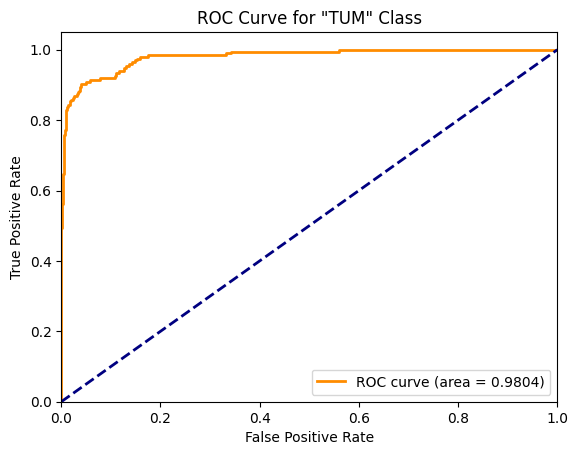

AUC for "TUM" class: 0.9804


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store all predicted probabilities and labels
all_probs = []
all_labels = []

# Collect the predicted probabilities and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model outputs (logits)
        outputs = model(inputs)
        # Apply softmax to get probabilities
        probs = torch.softmax(outputs, dim=1)

        # Append probabilities for the "TUM" class (index of 'TUM' class)
        all_probs.extend(probs[:, tum_class_idx].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert true labels to binary format (1 for 'TUM', 0 for other classes)
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(binary_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for "TUM" Class')
plt.legend(loc="lower right")
plt.show()

print(f'AUC for "TUM" class: {roc_auc:.4f}')


# Train with the stained normalization (light)

In [ ]:
def func_transform():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform

transformed = func_transform()

def loadDataset(transform_params):
    full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/stained_datasets_week8_H_1', transform= transform_params)


In [ ]:
full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/stained_datasets_week8_H_1', transform= transformed)

In [ ]:
total_size = len(full_dataset)
print(total_size)

6000


In [ ]:
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, )

In [ ]:
print(f"Number of total samples: {total_size}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Class names: {full_dataset.classes}")

Number of total samples: 6000
Number of training samples: 4800
Number of test samples: 1200
Number of classes: 6
Class names: ['ADI', 'DEBRIS_MUCUS', 'LYM', 'MUSC_STROMA', 'NORM', 'TUM']


In [ ]:
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


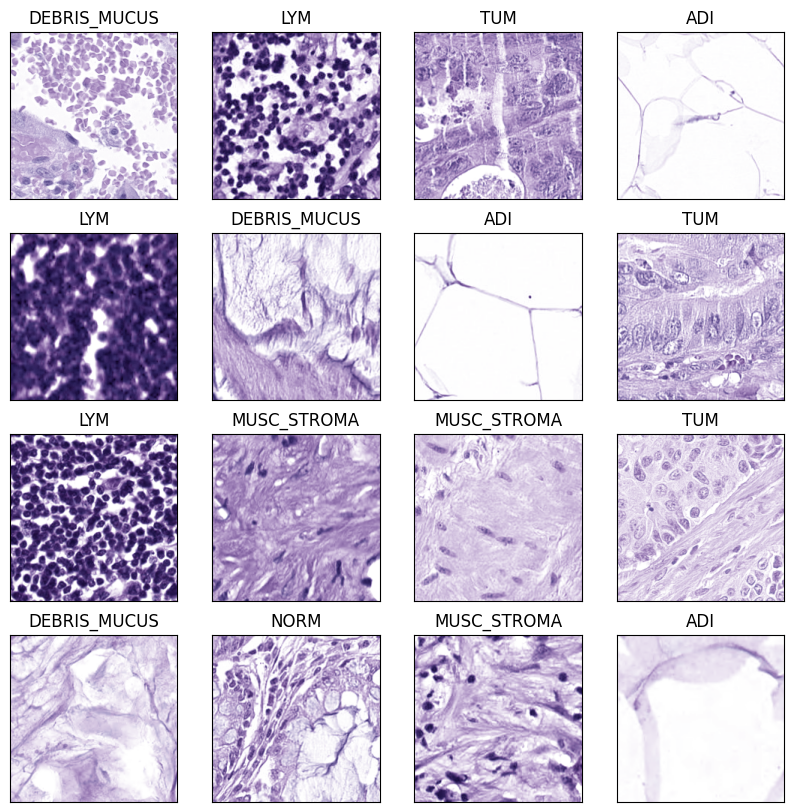

In [ ]:
plot_loader_ = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Visualise some examples
plt.figure(figsize=(10,10))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(plot_loader_))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))
    #image = image * std +mean
    plt.imshow(image)
    plt.title(full_dataset.classes[label])
plt.show()

In [ ]:
batch[1].numpy()[0]

0

In [ ]:
model2 = models.vgg16(pretrained=True).to(device)

for param in model1.parameters():
    param.requires_grad = False

model2.classifier[-1] = nn.Linear(4096, len(full_dataset.classes), bias=True)
model2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model = model2
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Loop over minibatches
    for inputs, labels in train_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    # Update learning rate
    scheduler.step()

    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)

In [ ]:
def evaluate_one_epoch(test_loader, model, criterion):
    # Eval mode
    model.eval()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in test_loader:
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss
            loss_epoch += loss.detach().item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    return loss_epoch/len(test_loader), accuracy_epoch.item()/len(test_loader)

In [ ]:
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, save_name):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.savefig(save_name)
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True):
    # Initialise outputs
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    # Loop over epochs
    for epoch in range(10):
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)

        # Evaluate
        test_loss, test_accuracy = evaluate_one_epoch(test_loader, model, criterion)

        # Track metrics
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)

        # Print loss
        if verbose:
            if (epoch+1)%1==0:
                print(f'Epoch {epoch+1}/{10}, loss {train_loss:.5f}, test_loss {test_loss:.5f}, accuracy {train_accuracy:.5f}, test_accuracy {test_accuracy:.5f}')

    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [ ]:
train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True)

Epoch 1/10, loss 1.80899, test_loss 1.14191, accuracy 0.36583, test_accuracy 0.50329
Epoch 2/10, loss 1.13149, test_loss 1.04966, accuracy 0.50813, test_accuracy 0.56826
Epoch 3/10, loss 1.07131, test_loss 0.95242, accuracy 0.55146, test_accuracy 0.60938
Epoch 4/10, loss 0.98176, test_loss 0.93486, accuracy 0.60500, test_accuracy 0.62253
Epoch 5/10, loss 0.91539, test_loss 0.86966, accuracy 0.64521, test_accuracy 0.65049
Epoch 6/10, loss 0.79677, test_loss 0.81207, accuracy 0.68917, test_accuracy 0.68339
Epoch 7/10, loss 0.69867, test_loss 0.70925, accuracy 0.72625, test_accuracy 0.73026
Epoch 8/10, loss 0.54769, test_loss 0.70627, accuracy 0.79604, test_accuracy 0.74424
Epoch 9/10, loss 0.41666, test_loss 0.57635, accuracy 0.85021, test_accuracy 0.81168
Epoch 10/10, loss 0.32514, test_loss 0.54539, accuracy 0.88583, test_accuracy 0.81990


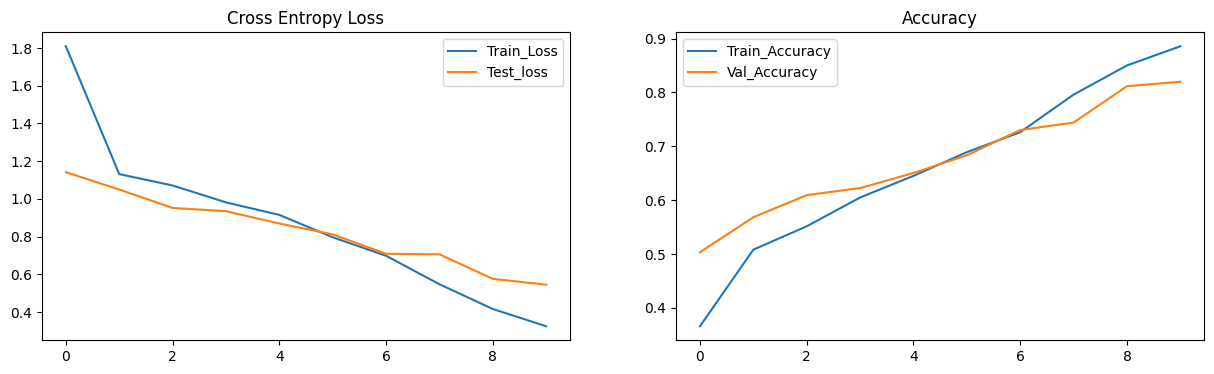

In [ ]:
plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, '/content/drive/MyDrive/vgg_stained.png')

In [ ]:
model.eval()

with torch.no_grad():
    n_correct=0
    n_samples=0

    n_class_correct = [0 for i in range(len(full_dataset.classes))]
    n_class_sample = [0 for i in range(len(full_dataset.classes))]

    for inputs, labels in test_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predictions
        _, preds = torch.max(outputs, 1)

        n_samples += labels.shape[0]
        n_correct += (preds == labels.data).sum().item()

        for i in range(32):
            try:
                label = labels[i].item()
                pred = preds[i].item()
            except:
                break

            if (label==pred):
                n_class_correct[label]+=1
            n_class_sample[label]+=1

    acc = 100 * n_correct/n_samples
    print(f'Overall accuracy on test set: {acc:.1f} %')

    for i in range(len(full_dataset.classes)):
        print(f'Accuracy of {full_dataset.classes[i]}: {100* n_class_correct[i]/n_class_sample[i]:.1f} %')

Overall accuracy on test set: 82.1 %
Accuracy of ADI: 96.2 %
Accuracy of DEBRIS_MUCUS: 67.7 %
Accuracy of LYM: 95.3 %
Accuracy of MUSC_STROMA: 76.7 %
Accuracy of NORM: 77.2 %
Accuracy of TUM: 79.2 %


In [ ]:
from sklearn.metrics import classification_report
all_predictions, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=['ADI', 'DEB', 'LYM', 'MUS', 'NORM', 'TUM'], digits=4)

print(report)

              precision    recall  f1-score   support

         ADI     0.9227    0.9621    0.9420       211
         DEB     0.6974    0.6766    0.6869       201
         LYM     0.8976    0.9534    0.9246       193
         MUS     0.8155    0.7671    0.7906       219
        NORM     0.7845    0.7717    0.7781       184
         TUM     0.7876    0.7917    0.7896       192

    accuracy                         0.8208      1200
   macro avg     0.8176    0.8204    0.8186      1200
weighted avg     0.8186    0.8208    0.8193      1200



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Define the target class index for "TUM"
tum_class_idx = full_dataset.class_to_idx['TUM']

# Initialize lists to store all predictions and labels
all_preds = []
all_labels = []

# Collect predictions and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate micro-average precision, recall, f1-score for "TUM" vs other classes
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]
binary_preds = [1 if pred == tum_class_idx else 0 for pred in all_preds]

precision, recall, f1_score, _ = precision_recall_fscore_support(binary_labels, binary_preds, average='micro')

# Print results
print(f"Precision (micro-average) for 'TUM' class: {precision:.4f}")
print(f"Recall (micro-average) for 'TUM' class: {recall:.4f}")
print(f"F1-Score (micro-average) for 'TUM' class: {f1_score:.4f}")


Precision (micro-average) for 'TUM' class: 0.9325
Recall (micro-average) for 'TUM' class: 0.9325
F1-Score (micro-average) for 'TUM' class: 0.9325


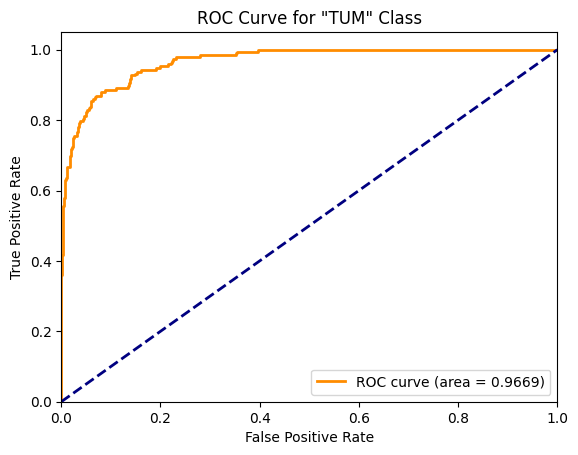

AUC for "TUM" class: 0.9669


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store all predicted probabilities and labels
all_probs = []
all_labels = []

# Collect the predicted probabilities and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model outputs (logits)
        outputs = model(inputs)
        # Apply softmax to get probabilities
        probs = torch.softmax(outputs, dim=1)

        # Append probabilities for the "TUM" class (index of 'TUM' class)
        all_probs.extend(probs[:, tum_class_idx].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert true labels to binary format (1 for 'TUM', 0 for other classes)
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(binary_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for "TUM" Class')
plt.legend(loc="lower right")
plt.show()

print(f'AUC for "TUM" class: {roc_auc:.4f}')

# Train with the stained normalization (dark)

In [ ]:
def func_transform():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform

transformed = func_transform()

def loadDataset(transform_params):
    full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/stained_datasets_week8_H_2', transform= transform_params)

In [ ]:
full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/stained_datasets_week8_H_2', transform= transformed)

In [ ]:
total_size = len(full_dataset)
print(total_size)

6000


In [ ]:
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, )

In [ ]:
print(f"Number of total samples: {total_size}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Class names: {full_dataset.classes}")

Number of total samples: 6000
Number of training samples: 4800
Number of test samples: 1200
Number of classes: 6
Class names: ['ADI', 'DEBRIS_MUCUS', 'LYM', 'MUSC_STROMA', 'NORM', 'TUM']


In [ ]:
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


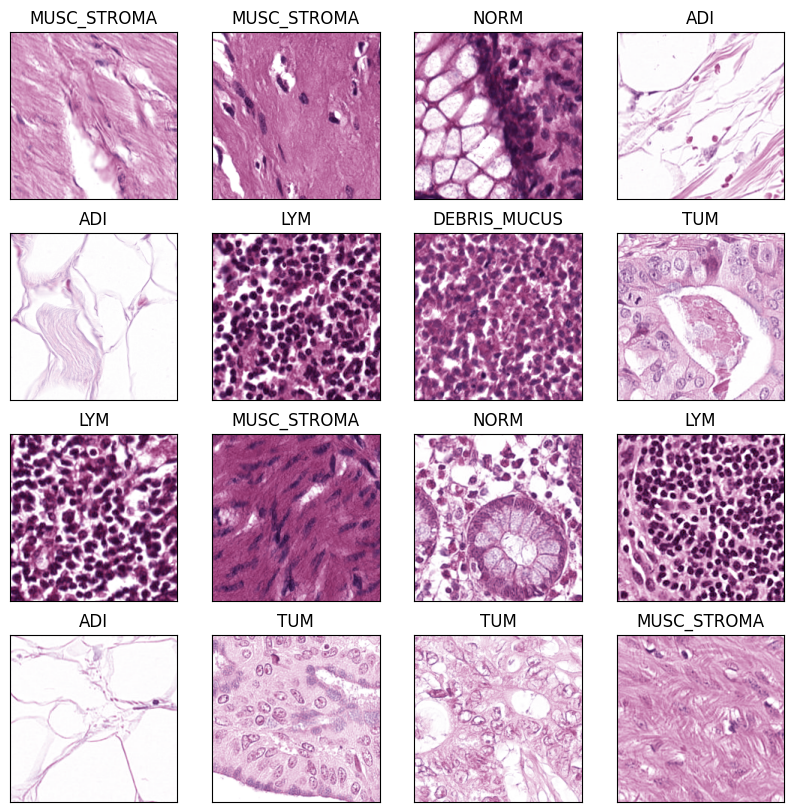

In [ ]:
plot_loader_ = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Visualise some examples
plt.figure(figsize=(10,10))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(plot_loader_))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))
    #image = image * std +mean
    plt.imshow(image)
    plt.title(full_dataset.classes[label])
plt.show()

In [ ]:
batch[1].numpy()[0]

3

In [ ]:
model1 = models.resnet50(pretrained=True).to(device)

for param in model1.parameters():
    param.requires_grad = False

model1.fc = nn.Sequential(
    nn.Linear(512, len(full_dataset.classes), bias=True)
)

In [ ]:
model2 = models.vgg16(pretrained=True).to(device)

for param in model1.parameters():
    param.requires_grad = False

model2.classifier[-1] = nn.Linear(4096, len(full_dataset.classes), bias=True)
model2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model = model2
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Loop over minibatches
    for inputs, labels in train_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    # Update learning rate
    scheduler.step()

    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)

In [ ]:
def evaluate_one_epoch(test_loader, model, criterion):
    # Eval mode
    model.eval()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in test_loader:
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss
            loss_epoch += loss.detach().item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    return loss_epoch/len(test_loader), accuracy_epoch.item()/len(test_loader)

In [ ]:
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, save_name):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.savefig(save_name)
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True):
    # Initialise outputs
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    # Loop over epochs
    for epoch in range(10):
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)

        # Evaluate
        test_loss, test_accuracy = evaluate_one_epoch(test_loader, model, criterion)

        # Track metrics
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)

        # Print loss
        if verbose:
            if (epoch+1)%1==0:
                print(f'Epoch {epoch+1}/{10}, loss {train_loss:.5f}, test_loss {test_loss:.5f}, accuracy {train_accuracy:.5f}, test_accuracy {test_accuracy:.5f}')

    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [ ]:
train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True)

Epoch 1/10, loss 1.42740, test_loss 1.86471, accuracy 0.40083, test_accuracy 0.38734
Epoch 2/10, loss 1.16525, test_loss 1.16998, accuracy 0.49896, test_accuracy 0.48684
Epoch 3/10, loss 1.08493, test_loss 1.07567, accuracy 0.53812, test_accuracy 0.54359
Epoch 4/10, loss 1.02997, test_loss 0.95375, accuracy 0.55417, test_accuracy 0.62664
Epoch 5/10, loss 0.92637, test_loss 1.16871, accuracy 0.61958, test_accuracy 0.55099
Epoch 6/10, loss 0.84969, test_loss 0.86781, accuracy 0.66354, test_accuracy 0.66530
Epoch 7/10, loss 0.71712, test_loss 1.02295, accuracy 0.72125, test_accuracy 0.63651
Epoch 8/10, loss 0.60926, test_loss 0.79274, accuracy 0.76667, test_accuracy 0.71875
Epoch 9/10, loss 0.47355, test_loss 0.54846, accuracy 0.82167, test_accuracy 0.79770
Epoch 10/10, loss 0.37114, test_loss 0.54793, accuracy 0.85917, test_accuracy 0.80181


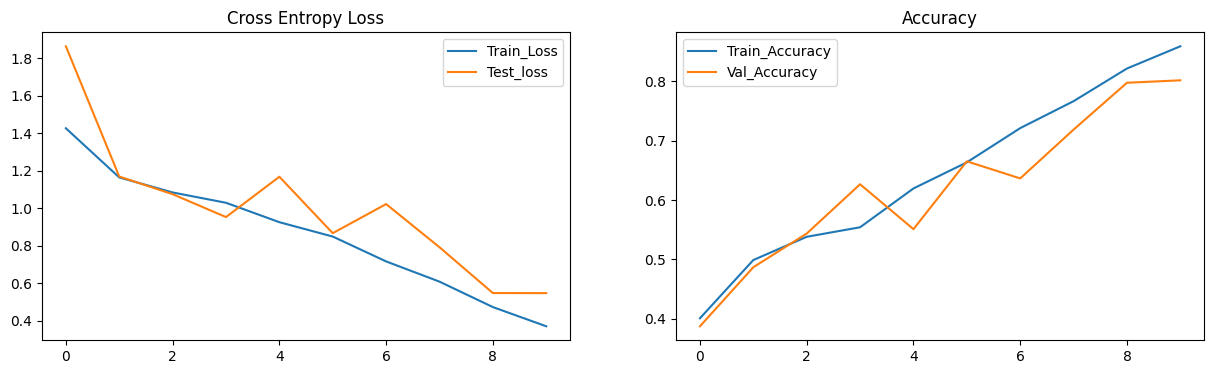

In [ ]:
plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, '/content/drive/MyDrive/vgg_stained_2.png')

In [ ]:
model.eval()

with torch.no_grad():
    n_correct=0
    n_samples=0

    n_class_correct = [0 for i in range(len(full_dataset.classes))]
    n_class_sample = [0 for i in range(len(full_dataset.classes))]

    for inputs, labels in test_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predictions
        _, preds = torch.max(outputs, 1)

        n_samples += labels.shape[0]
        n_correct += (preds == labels.data).sum().item()

        for i in range(32):
            try:
                label = labels[i].item()
                pred = preds[i].item()
            except:
                break

            if (label==pred):
                n_class_correct[label]+=1
            n_class_sample[label]+=1

    acc = 100 * n_correct/n_samples
    print(f'Overall accuracy on test set: {acc:.1f} %')

    for i in range(len(full_dataset.classes)):
        print(f'Accuracy of {full_dataset.classes[i]}: {100* n_class_correct[i]/n_class_sample[i]:.1f} %')

Overall accuracy on test set: 80.2 %
Accuracy of ADI: 95.7 %
Accuracy of DEBRIS_MUCUS: 60.1 %
Accuracy of LYM: 90.4 %
Accuracy of MUSC_STROMA: 77.6 %
Accuracy of NORM: 82.9 %
Accuracy of TUM: 76.5 %


In [ ]:
from sklearn.metrics import classification_report
all_predictions, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=['ADI', 'DEB', 'LYM', 'MUS', 'NORM', 'TUM'], digits=4)

print(report)

              precision    recall  f1-score   support

         ADI     0.9424    0.9574    0.9499       188
         DEB     0.6224    0.6010    0.6115       203
         LYM     0.8989    0.9040    0.9014       177
         MUS     0.8894    0.7763    0.8290       228
        NORM     0.7692    0.8295    0.7982       217
         TUM     0.7079    0.7647    0.7352       187

    accuracy                         0.8017      1200
   macro avg     0.8051    0.8055    0.8042      1200
weighted avg     0.8039    0.8017    0.8017      1200



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Define the target class index for "TUM"
tum_class_idx = full_dataset.class_to_idx['TUM']

# Initialize lists to store all predictions and labels
all_preds = []
all_labels = []

# Collect predictions and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate micro-average precision, recall, f1-score for "TUM" vs other classes
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]
binary_preds = [1 if pred == tum_class_idx else 0 for pred in all_preds]

precision, recall, f1_score, _ = precision_recall_fscore_support(binary_labels, binary_preds, average='micro')

# Print results
print(f"Precision (micro-average) for 'TUM' class: {precision:.4f}")
print(f"Recall (micro-average) for 'TUM' class: {recall:.4f}")
print(f"F1-Score (micro-average) for 'TUM' class: {f1_score:.4f}")

Precision (micro-average) for 'TUM' class: 0.9142
Recall (micro-average) for 'TUM' class: 0.9142
F1-Score (micro-average) for 'TUM' class: 0.9142


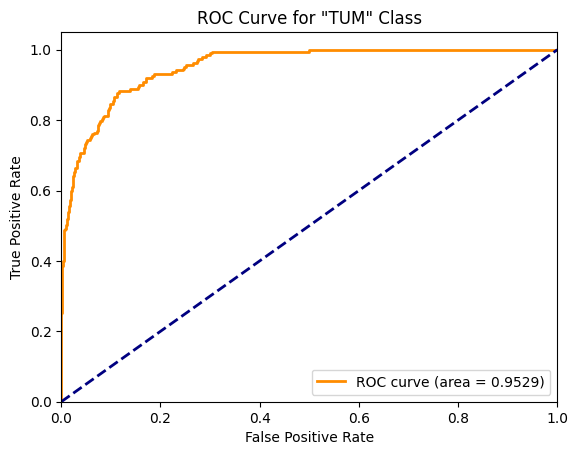

AUC for "TUM" class: 0.9529


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store all predicted probabilities and labels
all_probs = []
all_labels = []

# Collect the predicted probabilities and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model outputs (logits)
        outputs = model(inputs)
        # Apply softmax to get probabilities
        probs = torch.softmax(outputs, dim=1)

        # Append probabilities for the "TUM" class (index of 'TUM' class)
        all_probs.extend(probs[:, tum_class_idx].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert true labels to binary format (1 for 'TUM', 0 for other classes)
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(binary_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for "TUM" Class')
plt.legend(loc="lower right")
plt.show()

print(f'AUC for "TUM" class: {roc_auc:.4f}')

# randomly changing image color

In [ ]:
def func_transform():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform

def color_jitter_transform():
    transform = transforms.Compose([
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        ], p=0.15),  # 15% 概率随机调整颜色
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    return transform

transformed = func_transform()
def loadDataset(transform_params):
    full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/demo_datasets_week8_H', transform= transform_params)
full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/demo_datasets_week8_H', transform= transformed)
total_size = len(full_dataset)

In [ ]:
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = 32
train_dataset.dataset.transform = color_jitter_transform()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


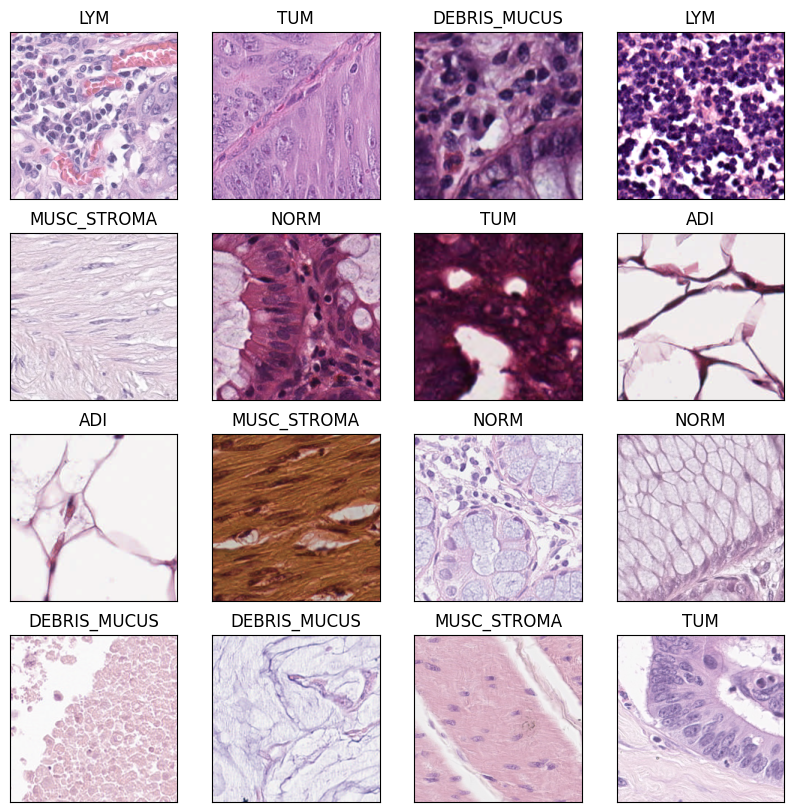

In [ ]:
plot_loader_ = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Visualise some examples
plt.figure(figsize=(10,10))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(plot_loader_))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))
    #image = image * std +mean
    plt.imshow(image)
    plt.title(full_dataset.classes[label])
plt.show()

In [ ]:
batch[1].numpy()[0]

5

In [ ]:
model1 = models.resnet50(pretrained=True).to(device)

for param in model1.parameters():
    param.requires_grad = False

model1.fc = nn.Sequential(
    nn.Linear(512, len(full_dataset.classes), bias=True)
)

In [ ]:
model2 = models.vgg16(pretrained=True).to(device)

for param in model1.parameters():
    param.requires_grad = False

model2.classifier[-1] = nn.Linear(4096, len(full_dataset.classes), bias=True)

In [ ]:
model = model2
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Loop over minibatches
    for inputs, labels in train_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    # Update learning rate
    scheduler.step()

    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)

In [ ]:
def evaluate_one_epoch(test_loader, model, criterion):
    # Eval mode
    model.eval()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in test_loader:
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss
            loss_epoch += loss.detach().item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    return loss_epoch/len(test_loader), accuracy_epoch.item()/len(test_loader)

In [ ]:
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, save_name):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.savefig(save_name)
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True):
    # Initialise outputs
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    # Loop over epochs
    for epoch in range(10):
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)

        # Evaluate
        test_loss, test_accuracy = evaluate_one_epoch(test_loader, model, criterion)

        # Track metrics
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)

        # Print loss
        if verbose:
            if (epoch+1)%1==0:
                print(f'Epoch {epoch+1}/{10}, loss {train_loss:.5f}, test_loss {test_loss:.5f}, accuracy {train_accuracy:.5f}, test_accuracy {test_accuracy:.5f}')

    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [ ]:
train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True)

Epoch 1/10, loss 1.79058, test_loss 1.54777, accuracy 0.32562, test_accuracy 0.32484
Epoch 2/10, loss 1.22052, test_loss 1.05708, accuracy 0.47563, test_accuracy 0.55181
Epoch 3/10, loss 1.10107, test_loss 1.08430, accuracy 0.51833, test_accuracy 0.53783
Epoch 4/10, loss 1.12557, test_loss 0.93551, accuracy 0.51479, test_accuracy 0.58964
Epoch 5/10, loss 0.97081, test_loss 0.90277, accuracy 0.57375, test_accuracy 0.59128
Epoch 6/10, loss 0.87631, test_loss 0.84769, accuracy 0.61187, test_accuracy 0.63898
Epoch 7/10, loss 0.81721, test_loss 0.88162, accuracy 0.64125, test_accuracy 0.63158
Epoch 8/10, loss 0.74977, test_loss 0.75479, accuracy 0.67563, test_accuracy 0.68092
Epoch 9/10, loss 0.70962, test_loss 0.71658, accuracy 0.69563, test_accuracy 0.69901
Epoch 10/10, loss 0.65822, test_loss 0.71784, accuracy 0.71604, test_accuracy 0.70806


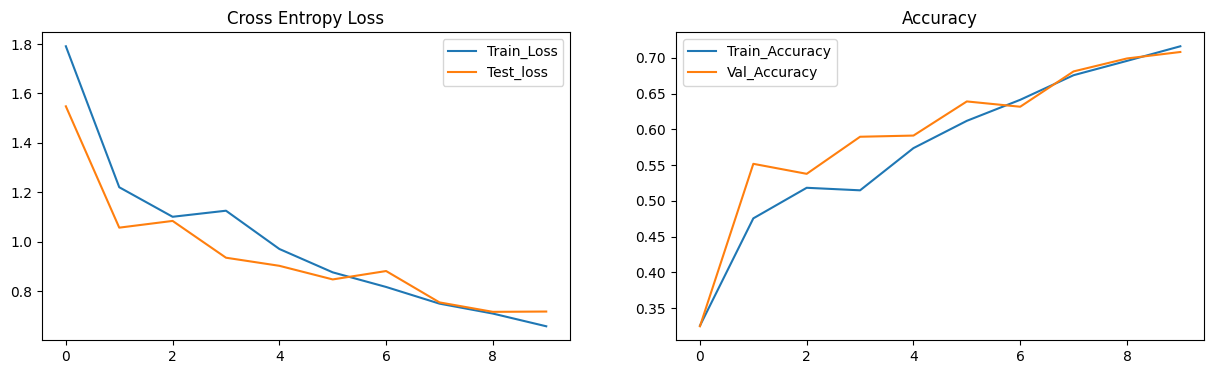

In [ ]:
plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, '/content/drive/MyDrive/vgg_changing_color.png')

In [ ]:
model.eval()

with torch.no_grad():
    n_correct=0
    n_samples=0

    n_class_correct = [0 for i in range(len(full_dataset.classes))]
    n_class_sample = [0 for i in range(len(full_dataset.classes))]

    for inputs, labels in test_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predictions
        _, preds = torch.max(outputs, 1)

        n_samples += labels.shape[0]
        n_correct += (preds == labels.data).sum().item()

        for i in range(32):
            try:
                label = labels[i].item()
                pred = preds[i].item()
            except:
                break

            if (label==pred):
                n_class_correct[label]+=1
            n_class_sample[label]+=1

    acc = 100 * n_correct/n_samples
    print(f'Overall accuracy on test set: {acc:.1f} %')

    for i in range(len(full_dataset.classes)):
        print(f'Accuracy of {full_dataset.classes[i]}: {100* n_class_correct[i]/n_class_sample[i]:.1f} %')

Overall accuracy on test set: 71.0 %
Accuracy of ADI: 99.5 %
Accuracy of DEBRIS_MUCUS: 29.4 %
Accuracy of LYM: 91.7 %
Accuracy of MUSC_STROMA: 77.5 %
Accuracy of NORM: 50.0 %
Accuracy of TUM: 71.5 %


In [ ]:
from sklearn.metrics import classification_report
all_predictions, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=['ADI', 'DEB', 'LYM', 'MUS', 'NORM', 'TUM'], digits=4)

print(report)

              precision    recall  f1-score   support

         ADI     0.9399    0.9910    0.9648       221
         DEB     0.6145    0.2833    0.3878       180
         LYM     0.8863    0.9167    0.9012       204
         MUS     0.5813    0.7647    0.6605       187
        NORM     0.5596    0.5192    0.5387       208
         TUM     0.6068    0.7100    0.6544       200

    accuracy                         0.7083      1200
   macro avg     0.6981    0.6975    0.6846      1200
weighted avg     0.7047    0.7083    0.6944      1200



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Define the target class index for "TUM"
tum_class_idx = full_dataset.class_to_idx['TUM']

# Initialize lists to store all predictions and labels
all_preds = []
all_labels = []

# Collect predictions and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate micro-average precision, recall, f1-score for "TUM" vs other classes
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]
binary_preds = [1 if pred == tum_class_idx else 0 for pred in all_preds]

precision, recall, f1_score, _ = precision_recall_fscore_support(binary_labels, binary_preds, average='micro')

# Print results
print(f"Precision (micro-average) for 'TUM' class: {precision:.4f}")
print(f"Recall (micro-average) for 'TUM' class: {recall:.4f}")
print(f"F1-Score (micro-average) for 'TUM' class: {f1_score:.4f}")

Precision (micro-average) for 'TUM' class: 0.8708
Recall (micro-average) for 'TUM' class: 0.8708
F1-Score (micro-average) for 'TUM' class: 0.8708


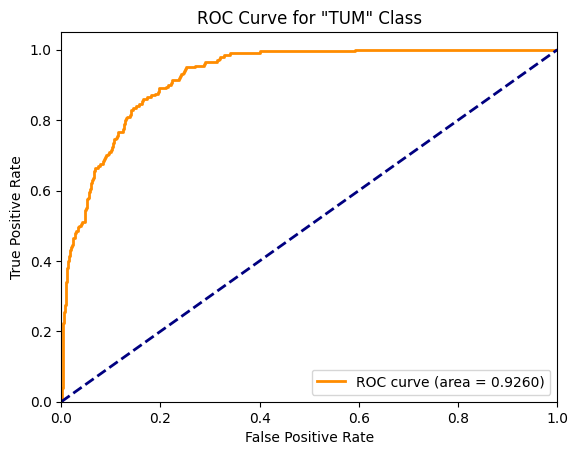

AUC for "TUM" class: 0.9260


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store all predicted probabilities and labels
all_probs = []
all_labels = []

# Collect the predicted probabilities and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model outputs (logits)
        outputs = model(inputs)
        # Apply softmax to get probabilities
        probs = torch.softmax(outputs, dim=1)

        # Append probabilities for the "TUM" class (index of 'TUM' class)
        all_probs.extend(probs[:, tum_class_idx].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert true labels to binary format (1 for 'TUM', 0 for other classes)
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(binary_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for "TUM" Class')
plt.legend(loc="lower right")
plt.show()

print(f'AUC for "TUM" class: {roc_auc:.4f}')

# randomly changing color + SPCN stained normalization

In [ ]:
def func_transform():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform

def color_jitter_transform():
    transform = transforms.Compose([
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        ], p=0.15),  # 15% 概率随机调整颜色
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform

transformed = func_transform()
def loadDataset(transform_params):
    full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/stained_datasets_week8_H_1', transform= transform_params)
full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/stained_datasets_week8_H_1', transform= transformed)
total_size = len(full_dataset)

In [ ]:
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = 32
train_dataset.dataset.transform = color_jitter_transform()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


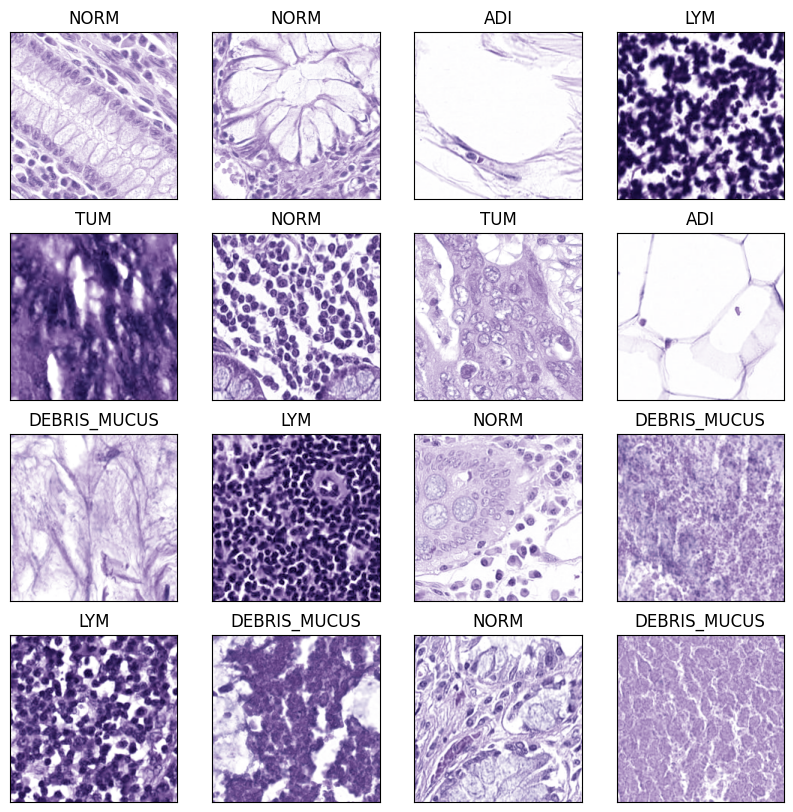

In [ ]:
plot_loader_ = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Visualise some examples
plt.figure(figsize=(10,10))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(plot_loader_))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))
    #image = image * std +mean
    plt.imshow(image)
    plt.title(full_dataset.classes[label])
plt.show()

In [ ]:
batch[1].numpy()[0]

1

In [ ]:
model1 = models.resnet50(pretrained=True).to(device)

for param in model1.parameters():
    param.requires_grad = False

model1.fc = nn.Sequential(
    nn.Linear(512, len(full_dataset.classes), bias=True)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model2 = models.vgg16(pretrained=True).to(device)

for param in model1.parameters():
    param.requires_grad = False

model2.classifier[-1] = nn.Linear(4096, len(full_dataset.classes), bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = model2
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Loop over minibatches
    for inputs, labels in train_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    # Update learning rate
    scheduler.step()

    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)

In [ ]:
def evaluate_one_epoch(test_loader, model, criterion):
    # Eval mode
    model.eval()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in test_loader:
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss
            loss_epoch += loss.detach().item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    return loss_epoch/len(test_loader), accuracy_epoch.item()/len(test_loader)

In [ ]:
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, save_name):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.savefig(save_name)
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True):
    # Initialise outputs
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    # Loop over epochs
    for epoch in range(10):
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)

        # Evaluate
        test_loss, test_accuracy = evaluate_one_epoch(test_loader, model, criterion)

        # Track metrics
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)

        # Print loss
        if verbose:
            if (epoch+1)%1==0:
                print(f'Epoch {epoch+1}/{10}, loss {train_loss:.5f}, test_loss {test_loss:.5f}, accuracy {train_accuracy:.5f}, test_accuracy {test_accuracy:.5f}')

    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [ ]:
train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True)

Epoch 1/10, loss 1.43959, test_loss 1.16679, accuracy 0.41500, test_accuracy 0.51562
Epoch 2/10, loss 1.10857, test_loss 1.00484, accuracy 0.52479, test_accuracy 0.56250
Epoch 3/10, loss 1.01560, test_loss 0.93560, accuracy 0.59021, test_accuracy 0.63240
Epoch 4/10, loss 0.93759, test_loss 0.88541, accuracy 0.62208, test_accuracy 0.64885
Epoch 5/10, loss 0.87948, test_loss 0.98568, accuracy 0.65354, test_accuracy 0.61349
Epoch 6/10, loss 0.77191, test_loss 0.95113, accuracy 0.70667, test_accuracy 0.62582
Epoch 7/10, loss 0.66217, test_loss 0.67869, accuracy 0.74813, test_accuracy 0.76809
Epoch 8/10, loss 0.48444, test_loss 0.56459, accuracy 0.82979, test_accuracy 0.80921
Epoch 9/10, loss 0.35308, test_loss 0.57722, accuracy 0.87458, test_accuracy 0.81826
Epoch 10/10, loss 0.28587, test_loss 0.51449, accuracy 0.90000, test_accuracy 0.83306


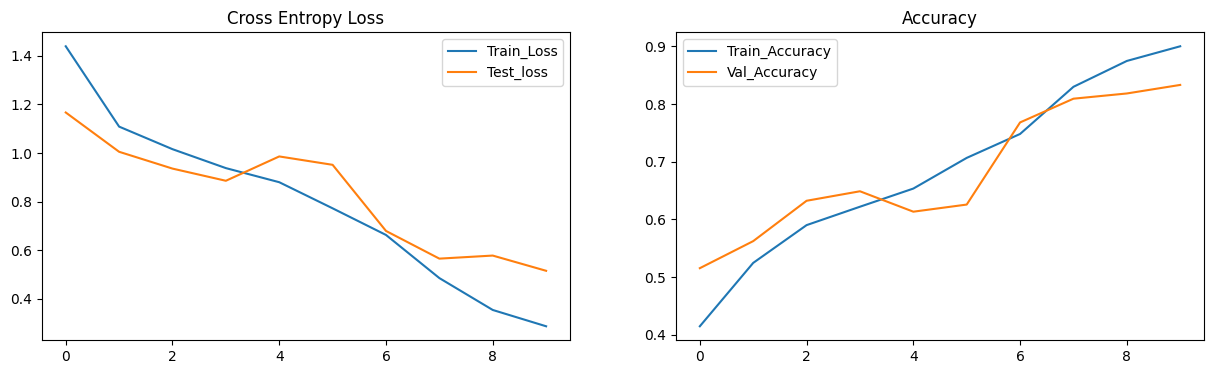

In [ ]:
plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, '/content/drive/MyDrive/vgg_stained+randomlycolor.png')

In [ ]:
model.eval()

with torch.no_grad():
    n_correct=0
    n_samples=0

    n_class_correct = [0 for i in range(len(full_dataset.classes))]
    n_class_sample = [0 for i in range(len(full_dataset.classes))]

    for inputs, labels in test_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Predictions
        _, preds = torch.max(outputs, 1)

        n_samples += labels.shape[0]
        n_correct += (preds == labels.data).sum().item()

        for i in range(32):
            try:
                label = labels[i].item()
                pred = preds[i].item()
            except:
                break

            if (label==pred):
                n_class_correct[label]+=1
            n_class_sample[label]+=1

    acc = 100 * n_correct/n_samples
    print(f'Overall accuracy on test set: {acc:.1f} %')

    for i in range(len(full_dataset.classes)):
        print(f'Accuracy of {full_dataset.classes[i]}: {100* n_class_correct[i]/n_class_sample[i]:.1f} %')

Overall accuracy on test set: 83.1 %
Accuracy of ADI: 97.1 %
Accuracy of DEBRIS_MUCUS: 73.0 %
Accuracy of LYM: 88.6 %
Accuracy of MUSC_STROMA: 76.6 %
Accuracy of NORM: 80.6 %
Accuracy of TUM: 83.0 %


In [ ]:
from sklearn.metrics import classification_report
all_predictions, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=['ADI', 'DEB', 'LYM', 'MUS', 'NORM', 'TUM'], digits=4)

print(report)

              precision    recall  f1-score   support

         ADI     0.9256    0.9707    0.9476       205
         DEB     0.7168    0.7535    0.7347       215
         LYM     0.9622    0.8856    0.9223       201
         MUS     0.8041    0.7610    0.7820       205
        NORM     0.7784    0.8118    0.7947       186
         TUM     0.8280    0.8191    0.8235       188

    accuracy                         0.8333      1200
   macro avg     0.8358    0.8336    0.8341      1200
weighted avg     0.8354    0.8333    0.8338      1200



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Define the target class index for "TUM"
tum_class_idx = full_dataset.class_to_idx['TUM']

# Initialize lists to store all predictions and labels
all_preds = []
all_labels = []

# Collect predictions and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate micro-average precision, recall, f1-score for "TUM" vs other classes
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]
binary_preds = [1 if pred == tum_class_idx else 0 for pred in all_preds]

precision, recall, f1_score, _ = precision_recall_fscore_support(binary_labels, binary_preds, average='micro')

# Print results
print(f"Precision (micro-average) for 'TUM' class: {precision:.4f}")
print(f"Recall (micro-average) for 'TUM' class: {recall:.4f}")
print(f"F1-Score (micro-average) for 'TUM' class: {f1_score:.4f}")

Precision (micro-average) for 'TUM' class: 0.9442
Recall (micro-average) for 'TUM' class: 0.9442
F1-Score (micro-average) for 'TUM' class: 0.9442


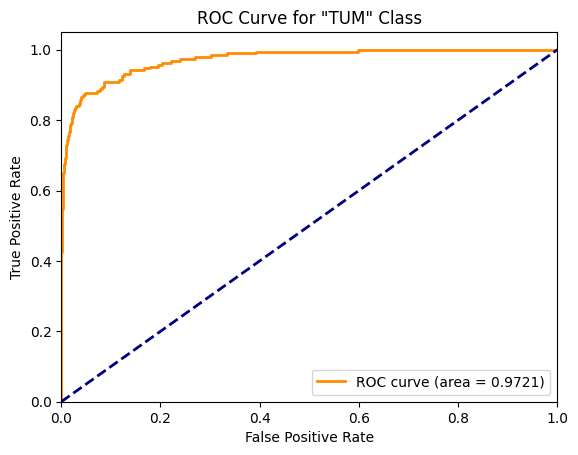

AUC for "TUM" class: 0.9721


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store all predicted probabilities and labels
all_probs = []
all_labels = []

# Collect the predicted probabilities and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model outputs (logits)
        outputs = model(inputs)
        # Apply softmax to get probabilities
        probs = torch.softmax(outputs, dim=1)

        # Append probabilities for the "TUM" class (index of 'TUM' class)
        all_probs.extend(probs[:, tum_class_idx].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert true labels to binary format (1 for 'TUM', 0 for other classes)
binary_labels = [1 if label == tum_class_idx else 0 for label in all_labels]

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(binary_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for "TUM" Class')
plt.legend(loc="lower right")
plt.show()

print(f'AUC for "TUM" class: {roc_auc:.4f}')